In [ ]:
from Data.weatherbench_128_v2 import WeatherBench128
from Models.FedorPredFormerGFT import PredFormer_Model
from LitModels.mutiout_fedor import MutiOut
from utils.metrics import Metrics

In [ ]:
import torch
import numpy as np
import xarray as xr
import torch
from torch import nn, einsum
from einops import rearrange
from einops.layers.torch import Rearrange
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import torch.nn.functional as F

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def lat(j: torch.Tensor, num_lat: int) -> torch.Tensor:
    return 90. - j * 180./float(num_lat-1)

latents_size = [32, 64] # patch size = 4, input size [128, 256], latents size = [128/4, 256/4]

radius = 6371.0 * 1000
num_lat = latents_size[0] + 2
lat_t = torch.arange(start=0, end=num_lat)
latitudes = lat(lat_t, num_lat)[1:-1]
latitudes = latitudes/180*torch.pi

c_lats = 2*torch.pi*radius*torch.cos(latitudes)
c_lats = c_lats.reshape([1, 1, latents_size[0], 1])

pixel_x = c_lats/latents_size[1] # The actual distance each pixel corresponds to in the horizontal direction
pixel_y = torch.pi*radius/(latents_size[0]+1) # The actual distance each pixel corresponds to in the vertical direction

pressure = torch.tensor([50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000]).reshape([1, 13, 1, 1])
pixel_z = torch.tensor([50, 50, 50, 50, 50, 75, 100, 100, 100, 125, 112, 75, 75]).reshape([1, 13, 1, 1]) # The difference between adjacent pressure levels, which will be used to calculate the p-direction integral


pressure_level_num = pixel_z.shape[1]
M_z = torch.zeros(pressure_level_num, pressure_level_num)
for M_z_i in range(pressure_level_num):
    for M_z_j in range(pressure_level_num):
        if M_z_i <= M_z_j:
            M_z[M_z_i, M_z_j] = pixel_z[0, M_z_j, 0, 0]


In [ ]:
train_start_time = '2000-01-01 00:00:00'
train_end_time = '2003-12-25 00:00:00' # '2000-01-01 23:00:00' #
val_start_time = '2004-01-01 00:00:00'
val_end_time = '2004-12-25 00:00:00' # '2004-01-01 23:00:00' #

train_data = WeatherBench128(start_time=train_start_time, end_time=train_end_time,
                            include_target=False, 
                            lead_time=1, 
                            interval=1,
                            muti_target_steps=1,
                            start_time_x=0,
                            end_time_x=120,      
                            start_time_y=12,
                            end_time_y=23)  
train_loader = DataLoader(train_data, batch_size=100, shuffle=True, num_workers=4)

In [ ]:
x_train, y_train = next(iter(train_loader))

In [ ]:
def x_to_zquvtw(x):
    """
    Преобразует входные данные x в формат zquvtw, пригодный для обработки через hybrid_block.

    Args:
        x: Входной тензор формы [B, C, H, W], где C - число каналов (обычно 65)

    Returns:
        zquvtw: Тензор формы [B, H//4, W//4, C] - пространственно понижающее преобразование и перестановка осей
    """
    # x имеет форму [B, C, H, W]
    B, C, H, W = x.shape

    # Понижающая дискретизация для уменьшения размера пространственных координат
    zquvtw = torch.nn.functional.interpolate(
        x, 
        size=(H//4, W//4), 
        mode='bilinear'
    )

    # Перестановка осей для формата [B, H, W, C], который ожидает HybridBlock
    # zquvtw = zquvtw.permute(0, 2, 3, 1)  # [B, H//4, W//4, C]

    return zquvtw

In [ ]:
# print(x_train[0, 0, 0].shape)

In [ ]:
# x_0 = x_train[:, 0, 4:]
# x_0 = x_to_zquvtw(x_0)

# x_1 = x_train[:, 1, 4:]
# x_1 = x_to_zquvtw(x_1)

In [ ]:
# x_0.shape

In [ ]:
# z_0, t_0, q_0, u_0, v_0 = x_0.chunk(5, dim=1)
# z_1, t_1, q_1, u_1, v_1 = x_1.chunk(5, dim=1)

In [ ]:
# x_0 = x_train[:, 0, 4:]
# x_0 = x_to_zquvtw(x_0)

# x_1 = x_train[:, 1, 4:]
# x_1 = x_to_zquvtw(x_1)

# kernel = PDE_kernel(block_dt=1200)
# idx = 2

In [ ]:
# for i in range(3):
#     x_0 = kernel(x_0)
#     z_0, t_0, q_0, u_0, v_0 = x_0.chunk(5, dim=1)
#     plt.figure(figsize=(15, 5))  # Широкий формат для трёх графиков в ряд

#     # Первое изображение: u_0
#     plt.subplot(1, 3, 1)
#     plt.imshow(u_0[idx, 0].detach().numpy())
#     plt.title("integrated u_0")
#     plt.colorbar()

#     # Второе изображение: u_1
#     plt.subplot(1, 3, 2)
#     plt.imshow(u_1[idx, 0].detach().numpy())
#     plt.title("u_1")
#     plt.colorbar()

#     # Разница: |u_1 - u_0|
#     plt.subplot(1, 3, 3)
#     plt.imshow(np.abs(u_1[idx, 0].detach().numpy() - u_0[idx, 0].detach().numpy()))
#     plt.title("|u_1 - u_0|")
#     plt.colorbar()

#     plt.tight_layout()
#     plt.savefig(f"pics/u_{i}.png")

In [ ]:
# plt.figure(figsize=(15, 5))  # Широкий формат для трёх графиков в ряд

# # Первое изображение: u_0
# plt.subplot(1, 3, 1)
# plt.imshow(u_0[idx, 0].detach().numpy())
# plt.title("u_0")
# plt.colorbar()

# # Второе изображение: u_1
# plt.subplot(1, 3, 2)
# plt.imshow(u_1[idx, 0].detach().numpy())
# plt.title("u_1")
# plt.colorbar()

# # Разница: |u_1 - u_0|
# plt.subplot(1, 3, 3)
# plt.imshow(np.abs(u_1[idx, 0].detach().numpy() - u_0[idx, 0].detach().numpy()))
# plt.title("|u_1 - u_0|")
# plt.colorbar()

# plt.tight_layout()
# plt.show()

In [ ]:
import imageio
import os
import re

def save_gif_from_folder(folder="pics", pattern=r"(\d+)_u0\.png", filename="animation.gif", duration=0.2, trange=24):
    """
    Создаёт GIF из изображений в папке, соответствующих шаблону имени.

    Аргументы:
        folder (str): Папка, где лежат картинки
        pattern (str): Регулярное выражение для фильтрации и сортировки файлов
        filename (str): Имя выходного GIF-файла
        duration (float): Длительность одного кадра в секундах
    """
    files = []
    
    for i in range(trange):
        files.append((os.path.join(folder, f"u_{i}.png")))
    
    # Сортируем по индексу
    files.sort(key=lambda x: x[0])
    
    # Загружаем изображения
    frames = [imageio.imread(fpath) for fpath in files]
    
    # Сохраняем gif
    imageio.mimsave(filename, frames, duration=duration)
    print(f"GIF сохранён как {filename}")


In [ ]:
mse_loss = torch.nn.MSELoss()
mae_loss = torch.nn.L1Loss()

In [ ]:
# Beta 

import torch
import torch.nn as nn
import torch.nn.functional as F

# ===== Исходные расчёты параметров дискретизации =====
latents_size = [32, 64]  # patch size = 4, input size [128, 256], latents size = [128/4, 256/4]
radius = 6371.0 * 1000
num_lat = latents_size[0] + 2
lat_t = torch.arange(start=0, end=num_lat)
# Функция для равномерного распределения широт от -90 до 90 градусов:
def lat(lat_t, num_lat):
    return torch.linspace(-90, 90, steps=num_lat)
latitudes = lat(lat_t, num_lat)[1:-1]
latitudes = latitudes / 180 * torch.pi  # переведём в радианы

c_lats = 2 * torch.pi * radius * torch.cos(latitudes)
c_lats = c_lats.reshape([1, 1, latents_size[0], 1])

pixel_x = c_lats / latents_size[1]  # Фактическое расстояние по горизонтали (ось x)
pixel_y = torch.pi * radius / (latents_size[0] + 1)  # Расстояние по вертикали (ось y)

pressure = torch.tensor([50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000]).reshape([1, 13, 1, 1])
pixel_z = torch.tensor([50, 50, 50, 50, 50, 75, 100, 100, 100, 125, 112, 75, 75]).reshape([1, 13, 1, 1])

pressure_level_num = pixel_z.shape[1]
M_z = torch.zeros(pressure_level_num, pressure_level_num)
for M_z_i in range(pressure_level_num):
    for M_z_j in range(pressure_level_num):
        if M_z_i <= M_z_j:
            M_z[M_z_i, M_z_j] = pixel_z[0, M_z_j, 0, 0]

def integral_z(input_tensor):
    # Вертикальное интегрирование по давлению
    B, pressure_level_num, H, W = input_tensor.shape
    input_tensor = input_tensor.reshape(B, pressure_level_num, H * W)
    output = M_z.to(input_tensor.dtype).to(input_tensor.device) @ input_tensor
    output = output.reshape(B, pressure_level_num, H, W)
    return output

# ===== Реализация WENO 5-го порядка для вычисления производных =====

def weno5_flux(u, epsilon=1e-6):
    """
    Вычисляет численный поток на интерфейсах ячеек по схеме WENO 5-го порядка.
    Предполагается upwind-смещённая аппроксимация.
    Периодические граничные условия реализованы через torch.roll.
    """
    u_m2 = torch.roll(u, shifts=2, dims=-1)  # u_{i-2}
    u_m1 = torch.roll(u, shifts=1, dims=-1)  # u_{i-1}
    u_0  = u                                # u_i
    u_p1 = torch.roll(u, shifts=-1, dims=-1)  # u_{i+1}
    u_p2 = torch.roll(u, shifts=-2, dims=-1)  # u_{i+2}

    f1 = (2 * u_m2 - 7 * u_m1 + 11 * u_0) / 6.0
    f2 = (-u_m1 + 5 * u_0 + 2 * u_p1) / 6.0
    f3 = (2 * u_0 + 5 * u_p1 - u_p2) / 6.0

    beta1 = (13/12.0) * (u_m2 - 2*u_m1 + u_0)**2 + (1/4.0) * (u_m2 - 4*u_m1 + 3*u_0)**2
    beta2 = (13/12.0) * (u_m1 - 2*u_0 + u_p1)**2 + (1/4.0) * (u_m1 - u_p1)**2
    beta3 = (13/12.0) * (u_0 - 2*u_p1 + u_p2)**2 + (1/4.0) * (3*u_0 - 4*u_p1 + u_p2)**2

    d1, d2, d3 = 0.1, 0.6, 0.3
    alpha1 = d1 / (1e-6 + beta1)**2
    alpha2 = d2 / (1e-6 + beta2)**2
    alpha3 = d3 / (1e-6 + beta3)**2

    alpha_sum = alpha1 + alpha2 + alpha3
    omega1 = alpha1 / alpha_sum
    omega2 = alpha2 / alpha_sum
    omega3 = alpha3 / alpha_sum

    flux_iphalf = omega1 * f1 + omega2 * f2 + omega3 * f3
    return flux_iphalf

def weno_derivative(u, dx, epsilon=1e-6):
    """
    Вычисляет первую производную функции u по последней оси с использованием WENO 5-го порядка.
    Аргументы:
      u       : тензор, по последней оси которого считается производная, размер (N, W)
      dx      : шаг по координате (скаляр, 0D или 1D тензор)
      epsilon : малое число для предотвращения деления на ноль.
    """
    flux_iphalf = weno5_flux(u, epsilon=epsilon)
    flux_imhalf = torch.roll(flux_iphalf, shifts=1, dims=-1)
    if not isinstance(dx, torch.Tensor):
        dx = torch.tensor(dx, dtype=u.dtype, device=u.device)
    if dx.dim() == 1:
        dx = dx.unsqueeze(-1)
    return (flux_iphalf - flux_imhalf) / dx

def d_x_weno(input_tensor):
    B, C, H, W = input_tensor.shape
    input_flat = input_tensor.reshape(B * C * H, W)
    dx_flat = pixel_x.expand(B, C, H, 1).reshape(B * C * H)
    derivative_flat = weno_derivative(input_flat, dx_flat)
    derivative = derivative_flat.reshape(B, C, H, W)
    return derivative

def d_y_weno(input_tensor):
    B, C, H, W = input_tensor.shape
    input_perm = input_tensor.permute(0, 1, 3, 2)
    input_flat = input_perm.reshape(B * C * W, H)
    derivative_flat = weno_derivative(input_flat, pixel_y)
    derivative_perm = derivative_flat.reshape(B, C, W, H)
    derivative = derivative_perm.permute(0, 1, 3, 2)
    return derivative

# Замена исходных функций d_x и d_y на их WENO-версии
d_x = d_x_weno
d_y = d_y_weno

def d_z(input_tensor):
    conv_kernel = torch.zeros([1, 1, 5, 1, 1], device=input_tensor.device, dtype=input_tensor.dtype, requires_grad=False)
    conv_kernel[0, 0, 0] = -1
    conv_kernel[0, 0, 1] = 8
    conv_kernel[0, 0, 3] = -8
    conv_kernel[0, 0, 4] = 1

    input_tensor = torch.cat((input_tensor[:, :2],
                              input_tensor,
                              input_tensor[:, -2:]), dim=1)
    input_tensor = input_tensor.unsqueeze(1)
    output_z = F.conv3d(input_tensor, conv_kernel) / 12
    output_z = output_z.squeeze(1)
    output_z = output_z / pixel_z.to(output_z.dtype).to(output_z.device)
    return output_z

def laplacian_tensor(u):
    d2u_dx2 = d_x(d_x(u))
    d2u_dy2 = d_y(d_y(u))
    return d2u_dx2 + d2u_dy2

# ===== Класс PDE_kernel с бета-подходом для коэффициента Кориолиса =====
#
# В текущей реализации коэффициент Кориолиса задаётся как
# f = f0 + beta * y,
# где y = R * lat (меридиональное расстояние в метрах).
#
class PDE_kernel(nn.Module):
    def __init__(self, variable_dim=13, block_dt=300, inverse_time=False, norm=False, eddy_viscosity=0.0,
                 beta=1.6e-11, f0=7.29e-5):
        """
        eddy_viscosity: коэффициент вихревой вязкости для субрешеточной турбулентности.
        beta: коэффициент бета, задающий изменение f по меридионали (с^-1 м^-1).
        f0: базовое значение коэффициента Кориолиса.
        """
        super().__init__()
        self.norm = norm
        self.eddy_viscosity = eddy_viscosity
        
        self.f0 = f0
        self.beta = beta
        # Вычисляем меридиональное расстояние y = R * lat для каждого пикселя по широте.
        # latitudes имеет форму [H], где H = latents_size[0]
        y_coords = radius * latitudes  # в метрах
        # f_field имеет форму [1, 1, H, 1] для вещания с полями [B, C, H, W]
        f_field = self.f0 + self.beta * y_coords
        self.register_buffer("f_field", f_field.reshape(1, 1, -1, 1))
        
        self.L = 2.5e6
        self.R = 8.314
        self.c_p = 1005
        self.R_v = 461.5
        self.R_d = 287
        self.diff_ratio = 0.05
        self.block_dt = block_dt
        if inverse_time:
            self.block_dt = -self.block_dt

        self.norm_z = nn.BatchNorm2d(variable_dim)
        self.norm_q = nn.BatchNorm2d(variable_dim)
        self.norm_u = nn.BatchNorm2d(variable_dim)
        self.norm_v = nn.BatchNorm2d(variable_dim)
        self.norm_t = nn.BatchNorm2d(variable_dim)

    def scale_tensor(self, tensor, a, b):
        min_val = tensor.min().detach()
        max_val = tensor.max().detach()
        scaled_tensor = (tensor - min_val) / (max_val - min_val)
        scaled_tensor = scaled_tensor * (b - a) + a
        return scaled_tensor
    
    def scale_diff(self, diff_x, x):
        x_min, x_mean, x_max = x.min().detach(), x.mean().detach(), x.max().detach()
        diff_min = (x_min - x_mean) * self.diff_ratio
        diff_max = (x_max - x_mean) * self.diff_ratio
        diff_x = self.scale_tensor(diff_x, diff_min, diff_max)
        return diff_x
    
    def avoid_inf(self, tensor, threshold=1.0):
        tensor = torch.where(torch.abs(tensor) == 0.0, torch.ones_like(tensor) * 0.1, tensor)
        tensor = torch.where(torch.abs(tensor) < threshold, torch.sign(tensor) * threshold, tensor)
        return tensor

    def share_z_dxyz(self, z):
        self.z_x = d_x(z)
        self.z_y = d_y(z)
        self.z_z = d_z(z)

    ############################# u, v #############################
    def get_uv_dt(self, u, v, w):
        # Вычисляем нелинейные адвективные члены в консервативной форме:
        # Для u: d_x(u*u) + d_y(u*v) + d_z(u*w)
        # Для v: d_x(u*v) + d_y(v*v) + d_z(v*w)
        adv_u = d_x(u * u) + d_y(u * v) + d_z(u * w)
        adv_v = d_x(u * v) + d_y(v * v) + d_z(v * w)
        
        # Используем f_field вместо фиксированного self.f
        self.u_t = -adv_u + self.f_field * v - self.z_x
        self.v_t = -adv_v - self.f_field * u - self.z_y

        if self.eddy_viscosity > 0:
            lap_u = laplacian_tensor(u)
            lap_v = laplacian_tensor(v)
            self.u_t += self.eddy_viscosity * lap_u
            self.v_t += self.eddy_viscosity * lap_v

        return self.u_t, self.v_t
    
    def uv_evolution(self, u, v, w):
        u_t, v_t = self.get_uv_dt(u, v, w)
        u = u + self.scale_diff(u_t * self.block_dt, u).detach()
        v = v + self.scale_diff(v_t * self.block_dt, v).detach()
        return u, v
    ################################################################
    
    ############################# t #############################
    def get_t_t(self, u, v, w, t):
        t_x = d_x(t)
        t_y = d_y(t)
        t_z = d_z(t)
        Q = -self.L * self.z_z * w
        self.t_t = (Q - self.z_z * w) / self.c_p - u * t_x - v * t_y - w * t_z
        return self.t_t
    
    def t_evolution(self, u, v, w, t):
        t_t = self.get_t_t(u, v, w, t)
        t = t + self.scale_diff(t_t * self.block_dt, t).detach()
        return t
    ################################################################

    ############################# z #############################
    def get_z_zt(self):    
        z_zt = -self.R / pressure.to(self.t_t.dtype).to(self.t_t.device) * self.t_t
        return z_zt
    
    def get_z_t(self):
        z_zt = self.get_z_zt()
        self.z_t = integral_z(z_zt)
        return self.z_t
    
    def z_evolution(self, z):
        z_t = self.get_z_t()
        z = z + self.scale_diff(z_t * self.block_dt, z).detach()
        return z
    ################################################################

    ############################# w #############################
    def get_w(self, u, v):
        self.u_x = d_x(u)
        self.v_y = d_y(v)
        w_z = - self.u_x - self.v_y
        w = integral_z(w_z).detach()
        return w
    ################################################################

    ############################# q #############################
    def get_q_dt(self, u, v, t, w, q):
        def get_qs(p, T):
            t_c = T - 273.15
            e_s = 6.112 * torch.exp(self.scale_tensor(17.67 * t_c / self.avoid_inf(t_c + 243.5), -3.47, 3.01)) * 100
            q_s = 0.622 * e_s / self.avoid_inf(p - 0.378 * e_s)
            return q_s

        def get_delta(p_t, q, q_s):
            cond = torch.logical_and(p_t < 0, torch.ge(q, q_s))
            return torch.where(cond, torch.ones_like(p_t), torch.zeros_like(p_t))

        def get_F(T, q, q_s):
            R_ = (1 + 0.608 * q) * self.R_d
            F_ = (self.L * R_ - self.c_p * self.R_v * T) / self.avoid_inf(self.c_p * self.R_v * T * T + self.L * self.L * q_s)
            F_ = F_ * q_s * T
            return F_

        q_x = d_x(q)
        q_y = d_y(q)
        q_z = d_z(q)

        rho = -1 / self.avoid_inf(self.z_z)
        p = rho * self.R * t

        q_s = get_qs(p, t).detach()
        q_s = torch.maximum(q_s, torch.ones_like(q_s) * 1e-6)
        delta = get_delta(self.z_t + u * self.z_x + v * self.z_y + w * self.z_z, q, q_s).detach()
        F_ = get_F(t, q, q_s).detach()

        q_t = -(u * q_x + v * q_y + w * q_z) + (self.z_t + u * self.z_x + v * self.z_y + w * self.z_z) * delta * F_ / self.avoid_inf(self.R * t)
        return q_t
    
    def q_evolution(self, u, v, t, w, q):
        q_t = self.get_q_dt(u, v, t, w, q)
        q = q + self.scale_diff(q_t * self.block_dt, q).detach()
        return q
    ################################################################

    def forward(self, zquvtw):
        # zquvtw имеет форму [B, 5 * variable_dim, H, W]
        z_old, t_old, q_old, u_old, v_old = zquvtw.chunk(5, dim=1)
        w_old = self.get_w(u_old, v_old)
        self.share_z_dxyz(z_old)
        u_new, v_new = self.uv_evolution(u_old, v_old, w_old)
        t_new = self.t_evolution(u_old, v_old, w_old, t_old)
        z_new = self.z_evolution(z_old)
        q_new = self.q_evolution(u_old, v_old, t_old, w_old, q_old)
        if self.norm:
            z_new = self.norm_z(z_new)
            q_new = self.norm_q(q_new)
            u_new = self.norm_u(u_new)
            v_new = self.norm_v(v_new)
            t_new = self.norm_t(t_new)
        zquvtw_new = torch.cat([z_new, t_new, q_new, u_new, v_new], dim=1)
        return zquvtw_new


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ===== Исходные расчёты параметров дискретизации =====
latents_size = [32, 64]  # patch size = 4, input size [128, 256], latents size = [128/4, 256/4]
radius = 6371.0 * 1000
num_lat = latents_size[0] + 2
lat_t = torch.arange(start=0, end=num_lat)
# Функция для равномерного распределения широт от -90 до 90 градусов:
def lat(lat_t, num_lat):
    return torch.linspace(-90, 90, steps=num_lat)
latitudes = lat(lat_t, num_lat)[1:-1]
latitudes = latitudes / 180 * torch.pi  # перевод в радианы

c_lats = 2 * torch.pi * radius * torch.cos(latitudes)
c_lats = c_lats.reshape([1, 1, latents_size[0], 1])

pixel_x = c_lats / latents_size[1]  # горизонтальное расстояние (ось x)
pixel_y = torch.pi * radius / (latents_size[0] + 1)  # вертикальное расстояние (ось y)

pressure = torch.tensor([50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000]).reshape([1, 13, 1, 1])
pixel_z = torch.tensor([50, 50, 50, 50, 50, 75, 100, 100, 100, 125, 112, 75, 75]).reshape([1, 13, 1, 1])

pressure_level_num = pixel_z.shape[1]
M_z = torch.zeros(pressure_level_num, pressure_level_num)
for M_z_i in range(pressure_level_num):
    for M_z_j in range(pressure_level_num):
        if M_z_i <= M_z_j:
            M_z[M_z_i, M_z_j] = pixel_z[0, M_z_j, 0, 0]

def integral_z(input_tensor):
    # Вертикальное интегрирование по давлению
    B, pressure_level_num, H, W = input_tensor.shape
    input_tensor = input_tensor.reshape(B, pressure_level_num, H * W)
    output = M_z.to(input_tensor.dtype).to(input_tensor.device) @ input_tensor
    output = output.reshape(B, pressure_level_num, H, W)
    return output

# ===== Реализация WENO 5-го порядка для вычисления производных =====

def weno5_flux(u, epsilon=1e-6, boundary="periodic"):
    """
    Вычисляет численный поток на интерфейсах ячеек по схеме WENO 5-го порядка.
    Аргументы:
      u        : тензор, по последней оси которого вычисляются срезы (форма (..., W))
      epsilon  : малое число для предотвращения деления на ноль.
      boundary : тип граничных условий: "periodic" или "reflect".
    """
    if boundary == "periodic":
        u_m2 = torch.roll(u, shifts=2, dims=-1)  # u_{i-2}
        u_m1 = torch.roll(u, shifts=1, dims=-1)  # u_{i-1}
        u_0  = u                                # u_i
        u_p1 = torch.roll(u, shifts=-1, dims=-1)  # u_{i+1}
        u_p2 = torch.roll(u, shifts=-2, dims=-1)  # u_{i+2}
    elif boundary == "reflect":
        # Отражающее дополнение: pad=(2,2) по последней оси
        u_pad = F.pad(u, pad=(2, 2), mode="reflect")
        u_m2 = u_pad[..., 0:-4]
        u_m1 = u_pad[..., 1:-3]
        u_0  = u_pad[..., 2:-2]
        u_p1 = u_pad[..., 3:-1]
        u_p2 = u_pad[..., 4:]
    else:
        raise ValueError("Unknown boundary condition")
        
    f1 = (2 * u_m2 - 7 * u_m1 + 11 * u_0) / 6.0
    f2 = (-u_m1 + 5 * u_0 + 2 * u_p1) / 6.0
    f3 = (2 * u_0 + 5 * u_p1 - u_p2) / 6.0

    beta1 = (13/12.0) * (u_m2 - 2*u_m1 + u_0)**2 + (1/4.0) * (u_m2 - 4*u_m1 + 3*u_0)**2
    beta2 = (13/12.0) * (u_m1 - 2*u_0 + u_p1)**2 + (1/4.0) * (u_m1 - u_p1)**2
    beta3 = (13/12.0) * (u_0 - 2*u_p1 + u_p2)**2 + (1/4.0) * (3*u_0 - 4*u_p1 + u_p2)**2

    d1, d2, d3 = 0.1, 0.6, 0.3
    alpha1 = d1 / (epsilon + beta1)**2
    alpha2 = d2 / (epsilon + beta2)**2
    alpha3 = d3 / (epsilon + beta3)**2

    alpha_sum = alpha1 + alpha2 + alpha3
    omega1 = alpha1 / alpha_sum
    omega2 = alpha2 / alpha_sum
    omega3 = alpha3 / alpha_sum

    flux_iphalf = omega1 * f1 + omega2 * f2 + omega3 * f3
    return flux_iphalf

def weno_derivative(u, dx, epsilon=1e-6, boundary="periodic"):
    """
    Вычисляет первую производную функции u по последней оси с использованием WENO 5-го порядка.
    Аргументы:
      u        : тензор с формой (N, W), по последней оси которого считается производная.
      dx       : шаг по координате (скаляр или 0D/1D тензор).
      boundary : тип граничных условий ("periodic" или "reflect").
    """
    flux_iphalf = weno5_flux(u, epsilon=epsilon, boundary=boundary)
    if boundary == "periodic":
        flux_imhalf = torch.roll(flux_iphalf, shifts=1, dims=-1)
    elif boundary == "reflect":
        flux_imhalf = flux_iphalf.clone()
        flux_imhalf[..., 1:] = flux_iphalf[..., :-1]
        flux_imhalf[..., 0] = flux_iphalf[..., 0]
    else:
        raise ValueError("Unknown boundary condition")
    
    if not isinstance(dx, torch.Tensor):
        dx = torch.tensor(dx, dtype=u.dtype, device=u.device)
    if dx.dim() == 1:
        dx = dx.unsqueeze(-1)
    return (flux_iphalf - flux_imhalf) / dx

def d_x_weno(input_tensor, boundary="reflect"):
    """
    Вычисляет производную по оси 3 (ширина) с использованием WENO 5-го порядка.
    Результат масштабируется с помощью pixel_x.
    """
    B, C, H, W = input_tensor.shape
    input_flat = input_tensor.reshape(B * C * H, W)
    dx_flat = pixel_x.expand(B, C, H, 1).reshape(B * C * H)
    derivative_flat = weno_derivative(input_flat, dx_flat, boundary=boundary)
    derivative = derivative_flat.reshape(B, C, H, W)
    return derivative

def d_y_weno(input_tensor, boundary="reflect"):
    """
    Вычисляет производную по оси 2 (высота) с использованием WENO 5-го порядка.
    Результат масштабируется с помощью pixel_y.
    """
    B, C, H, W = input_tensor.shape
    input_perm = input_tensor.permute(0, 1, 3, 2)
    input_flat = input_perm.reshape(B * C * W, H)
    derivative_flat = weno_derivative(input_flat, pixel_y, boundary=boundary)
    derivative_perm = derivative_flat.reshape(B, C, W, H)
    derivative = derivative_perm.permute(0, 1, 3, 2)
    return derivative

# Используем функции d_x_weno и d_y_weno напрямую
d_x = d_x_weno
d_y = d_y_weno

def d_z(input_tensor):
    # Вертикальная производная по давлению без изменений (используется периодическая логика через concat)
    conv_kernel = torch.zeros([1, 1, 5, 1, 1], device=input_tensor.device, dtype=input_tensor.dtype, requires_grad=False)
    conv_kernel[0, 0, 0] = -1
    conv_kernel[0, 0, 1] = 8
    conv_kernel[0, 0, 3] = -8
    conv_kernel[0, 0, 4] = 1

    input_tensor = torch.cat((input_tensor[:, :2],
                              input_tensor,
                              input_tensor[:, -2:]), dim=1)
    input_tensor = input_tensor.unsqueeze(1)  # [B, 1, C, H, W]
    output_z = F.conv3d(input_tensor, conv_kernel) / 12
    output_z = output_z.squeeze(1)
    output_z = output_z / pixel_z.to(output_z.dtype).to(output_z.device)
    return output_z

def laplacian_tensor(u):
    d2u_dx2 = d_x(d_x(u))
    d2u_dy2 = d_y(d_y(u))
    return d2u_dx2 + d2u_dy2

# ===== Функции для адаптивного уточнения сетки (AMR) =====

def adaptive_mesh_refinement(field, grad_threshold=1e-3, upscale_factor=2):
    """
    Если максимальное значение градиента (вычисляемого с помощью d_x и d_y) превышает grad_threshold,
    возвращает уточнённое поле с увеличенным разрешением (с использованием F.interpolate).
    """
    grad_field = torch.sqrt(d_x(field)**2 + d_y(field)**2)
    if grad_field.max() > grad_threshold:
        refined_field = F.interpolate(field, scale_factor=upscale_factor, mode='bilinear', align_corners=True)
        return refined_field, True
    else:
        return field, False

def compute_derivative_with_amr(field, derivative_fn, grad_threshold=1e-3, upscale_factor=2, boundary="reflect"):
    """
    Вычисляет производную поля с использованием AMR.
    Если поле имеет сильные градиенты (макс. значение > grad_threshold), оно уточняется,
    затем вычисляется производная на уточнённом поле, и результат обратно интерполируется до исходного разрешения.
    """
    refined_field, refined = adaptive_mesh_refinement(field, grad_threshold, upscale_factor)
    if refined:
        refined_deriv = derivative_fn(refined_field, boundary=boundary)
        deriv = F.interpolate(refined_deriv, scale_factor=1/upscale_factor, mode='bilinear', align_corners=True)
        return deriv
    else:
        return derivative_fn(field, boundary=boundary)

# ===== Класс PDE_kernel с учётом бета-подхода, улучшенных граничных условий и AMR =====
#
# Коэффициент Кориолиса определяется как:
#     f = f0 + beta * y,
# где y = R * lat (меридиональное расстояние в метрах).
#
class PDE_kernel(nn.Module):
    def __init__(self, variable_dim=13, block_dt=300, inverse_time=False, norm=False, eddy_viscosity=0.0,
                 beta=1.6e-11, f0=7.29e-5):
        """
        eddy_viscosity: коэффициент вихревой вязкости для субрешеточной турбулентности.
        beta: коэффициент бета (с^-1 м^-1) для вариации f по меридионали.
        f0: базовое значение коэффициента Кориолиса.
        """
        super().__init__()
        self.norm = norm
        self.eddy_viscosity = eddy_viscosity
        
        self.f0 = f0
        self.beta = beta
        # Вычисляем меридиональное расстояние y = R * lat для каждого пикселя по широте.
        y_coords = radius * latitudes  # в метрах
        # f_field имеет форму [1, 1, H, 1] для вещания с полями [B, C, H, W]
        f_field = self.f0 + self.beta * y_coords
        self.register_buffer("f_field", f_field.reshape(1, 1, -1, 1))
        
        self.L = 2.5e6
        self.R = 8.314
        self.c_p = 1005
        self.R_v = 461.5
        self.R_d = 287
        self.diff_ratio = 0.05
        self.block_dt = block_dt
        if inverse_time:
            self.block_dt = -self.block_dt

        self.norm_z = nn.BatchNorm2d(variable_dim)
        self.norm_q = nn.BatchNorm2d(variable_dim)
        self.norm_u = nn.BatchNorm2d(variable_dim)
        self.norm_v = nn.BatchNorm2d(variable_dim)
        self.norm_t = nn.BatchNorm2d(variable_dim)

    def scale_tensor(self, tensor, a, b):
        min_val = tensor.min().detach()
        max_val = tensor.max().detach()
        scaled_tensor = (tensor - min_val) / (max_val - min_val)
        return scaled_tensor * (b - a) + a
    
    def scale_diff(self, diff_x, x):
        x_min, x_mean, x_max = x.min().detach(), x.mean().detach(), x.max().detach()
        diff_min = (x_min - x_mean) * self.diff_ratio
        diff_max = (x_max - x_mean) * self.diff_ratio
        return self.scale_tensor(diff_x, diff_min, diff_max)
    
    def avoid_inf(self, tensor, threshold=1.0):
        tensor = torch.where(torch.abs(tensor) == 0.0, torch.ones_like(tensor) * 0.1, tensor)
        return torch.where(torch.abs(tensor) < threshold, torch.sign(tensor) * threshold, tensor)

    def share_z_dxyz(self, z):
        self.z_x = d_x(z)
        self.z_y = d_y(z)
        self.z_z = d_z(z)

    ############################# u, v #############################
    def get_uv_dt(self, u, v, w):
        # Консервативное представление нелинейных членов с применением AMR для уточнения
        adv_u = compute_derivative_with_amr(u * u, d_x) \
              + compute_derivative_with_amr(u * v, d_y) \
              + d_z(u * w)  # вертикальная производная без AMR
        adv_v = compute_derivative_with_amr(u * v, d_x) \
              + compute_derivative_with_amr(v * v, d_y) \
              + d_z(v * w)
        
        # Используем f_field (вариация по широте)
        self.u_t = -adv_u + self.f_field * v - self.z_x
        self.v_t = -adv_v - self.f_field * u - self.z_y

        # Параметризация субрешеточной турбулентности через вихревую вязкость
        if self.eddy_viscosity > 0:
            lap_u = laplacian_tensor(u)
            lap_v = laplacian_tensor(v)
            self.u_t += self.eddy_viscosity * lap_u
            self.v_t += self.eddy_viscosity * lap_v

        return self.u_t, self.v_t
    
    def uv_evolution(self, u, v, w):
        u_t, v_t = self.get_uv_dt(u, v, w)
        u = u + self.scale_diff(u_t * self.block_dt, u).detach()
        v = v + self.scale_diff(v_t * self.block_dt, v).detach()
        return u, v
    ################################################################
    
    ############################# t #############################
    def get_t_t(self, u, v, w, t):
        t_x = d_x(t)
        t_y = d_y(t)
        t_z = d_z(t)
        Q = -self.L * self.z_z * w
        self.t_t = (Q - self.z_z * w) / self.c_p - u * t_x - v * t_y - w * t_z
        return self.t_t
    
    def t_evolution(self, u, v, w, t):
        t_t = self.get_t_t(u, v, w, t)
        return t + self.scale_diff(t_t * self.block_dt, t).detach()
    ################################################################

    ############################# z #############################
    def get_z_zt(self):    
        return -self.R / pressure.to(self.t_t.dtype).to(self.t_t.device) * self.t_t
    
    def get_z_t(self):
        z_zt = self.get_z_zt()
        self.z_t = integral_z(z_zt)
        return self.z_t
    
    def z_evolution(self, z):
        z_t = self.get_z_t()
        return z + self.scale_diff(z_t * self.block_dt, z).detach()
    ################################################################

    ############################# w #############################
    def get_w(self, u, v):
        self.u_x = d_x(u)
        self.v_y = d_y(v)
        w_z = - self.u_x - self.v_y
        return integral_z(w_z).detach()
    ################################################################

    ############################# q #############################
    def get_q_dt(self, u, v, t, w, q):
        def get_qs(p, T):
            t_c = T - 273.15
            e_s = 6.112 * torch.exp(self.scale_tensor(17.67 * t_c / self.avoid_inf(t_c + 243.5), -3.47, 3.01)) * 100
            return 0.622 * e_s / self.avoid_inf(p - 0.378 * e_s)

        def get_delta(p_t, q, q_s):
            cond = torch.logical_and(p_t < 0, torch.ge(q, q_s))
            return torch.where(cond, torch.ones_like(p_t), torch.zeros_like(p_t))

        def get_F(T, q, q_s):
            R_ = (1 + 0.608 * q) * self.R_d
            F_ = (self.L * R_ - self.c_p * self.R_v * T) / self.avoid_inf(self.c_p * self.R_v * T * T + self.L * self.L * q_s)
            return F_ * q_s * T

        q_x = d_x(q)
        q_y = d_y(q)
        q_z = d_z(q)

        rho = -1 / self.avoid_inf(self.z_z)
        p = rho * self.R * t

        q_s = get_qs(p, t).detach()
        q_s = torch.maximum(q_s, torch.ones_like(q_s) * 1e-6)
        delta = get_delta(self.z_t + u * self.z_x + v * self.z_y + w * self.z_z, q, q_s).detach()
        F_ = get_F(t, q, q_s).detach()

        q_t = -(u * q_x + v * q_y + w * q_z) + (self.z_t + u * self.z_x + v * self.z_y + w * self.z_z) * delta * F_ / self.avoid_inf(self.R * t)
        return q_t
    
    def q_evolution(self, u, v, t, w, q):
        q_t = self.get_q_dt(u, v, t, w, q)
        return q + self.scale_diff(q_t * self.block_dt, q).detach()
    ################################################################

    def forward(self, zquvtw):
        # zquvtw имеет форму [B, 5 * variable_dim, H, W]
        z_old, t_old, q_old, u_old, v_old = zquvtw.chunk(5, dim=1)
        w_old = self.get_w(u_old, v_old)
        self.share_z_dxyz(z_old)
        u_new, v_new = self.uv_evolution(u_old, v_old, w_old)
        t_new = self.t_evolution(u_old, v_old, w_old, t_old)
        z_new = self.z_evolution(z_old)
        q_new = self.q_evolution(u_old, v_old, t_old, w_old, q_old)
        if self.norm:
            z_new = self.norm_z(z_new)
            q_new = self.norm_q(q_new)
            u_new = self.norm_u(u_new)
            v_new = self.norm_v(v_new)
            t_new = self.norm_t(t_new)
        return torch.cat([z_new, t_new, q_new, u_new, v_new], dim=1)


In [ ]:
u_mse_1200_bez = []
u_mae_1200_bez = []

v_mse_1200_bez = []
v_mae_1200_bez = []

z_mse_1200_bez = []
z_mae_1200_bez = []

q_mse_1200_bez = []
q_mae_1200_bez = []

t_mse_1200_bez = []
t_mae_1200_bez = []

kernel = PDE_kernel(block_dt=1200)
x_0 = x_train[:, 0, 4:]
x_0 = x_to_zquvtw(x_0)

for i in range(110):

    x_1 = x_train[:, i+1, 4:]
    x_1 = x_to_zquvtw(x_1)
    
    for i in range(3):
        x_0 = kernel(x_0)
        z_0, t_0, q_0, u_0, v_0 = x_0.chunk(5, dim=1)
    
    z_1, t_1, q_1, u_1, v_1 = x_1.chunk(5, dim=1)
    
    u_mse_1200_bez.append(mse_loss(u_0, u_1).item())
    u_mae_1200_bez.append(mae_loss(u_0, u_1).item())
    
    v_mse_1200_bez.append(mse_loss(v_0, v_1).item())
    v_mae_1200_bez.append(mae_loss(v_0, v_1).item())
    
    q_mse_1200_bez.append(mse_loss(q_0, q_1).item())
    q_mae_1200_bez.append(mae_loss(q_0, q_1).item())
    
    t_mse_1200_bez.append(mse_loss(t_0, t_1).item())
    t_mae_1200_bez.append(mae_loss(t_0, t_1).item())
    
    z_mse_1200_bez.append(mse_loss(z_0, z_1).item())
    z_mae_1200_bez.append(mae_loss(z_0, z_1).item())
    
    

In [ ]:
# u_mse_300_bez = []
# u_mae_300_bez = []

# v_mse_300_bez = []
# v_mae_300_bez = []

# z_mse_300_bez = []
# z_mae_300_bez = []

# q_mse_300_bez = []
# q_mae_300_bez = []

# t_mse_300_bez = []
# t_mae_300_bez = []

# kernel = PDE_kernel(block_dt=300)
# x_0 = x_train[:, 0, 4:]
# x_0 = x_to_zquvtw(x_0)

# for i in range(11):

#     x_1 = x_train[:, i+1, 4:]
#     x_1 = x_to_zquvtw(x_1)
    
#     for i in range(12):
#         x_0 = kernel(x_0)
#         z_0, t_0, q_0, u_0, v_0 = x_0.chunk(5, dim=1)
    
#     z_1, t_1, q_1, u_1, v_1 = x_1.chunk(5, dim=1)
    
#     u_mse_300_bez.append(mse_loss(u_0, u_1).item())
#     u_mae_300_bez.append(mae_loss(u_0, u_1).item())
    
#     v_mse_300_bez.append(mse_loss(v_0, v_1).item())
#     v_mae_300_bez.append(mae_loss(v_0, v_1).item())
    
#     q_mse_300_bez.append(mse_loss(q_0, q_1).item())
#     q_mae_300_bez.append(mae_loss(q_0, q_1).item())
    
#     t_mse_300_bez.append(mse_loss(t_0, t_1).item())
#     t_mae_300_bez.append(mae_loss(t_0, t_1).item())
    
#     z_mse_300_bez.append(mse_loss(z_0, z_1).item())
#     z_mae_300_bez.append(mae_loss(z_0, z_1).item())
    

In [ ]:
u_mse_1200 = []
u_mae_1200 = []

v_mse_1200 = []
v_mae_1200 = []

z_mse_1200 = []
z_mae_1200 = []

q_mse_1200 = []
q_mae_1200 = []

t_mse_1200 = []
t_mae_1200 = []

kernel = PDE_kernel(block_dt=1200, norm=True)
x_0 = x_train[:, 0, 4:]
x_0 = x_to_zquvtw(x_0)

for i in range(110):

    x_1 = x_train[:, i+1, 4:]
    x_1 = x_to_zquvtw(x_1)
    
    for i in range(3):
        x_0 = kernel(x_0)
        z_0, t_0, q_0, u_0, v_0 = x_0.chunk(5, dim=1)
    
    z_1, t_1, q_1, u_1, v_1 = x_1.chunk(5, dim=1)
    
    u_mse_1200.append(mse_loss(u_0, u_1).item())
    u_mae_1200.append(mae_loss(u_0, u_1).item())
    
    v_mse_1200.append(mse_loss(v_0, v_1).item())
    v_mae_1200.append(mae_loss(v_0, v_1).item())
    
    q_mse_1200.append(mse_loss(q_0, q_1).item())
    q_mae_1200.append(mae_loss(q_0, q_1).item())
    
    t_mse_1200.append(mse_loss(t_0, t_1).item())
    t_mae_1200.append(mae_loss(t_0, t_1).item())
    
    z_mse_1200.append(mse_loss(z_0, z_1).item())
    z_mae_1200.append(mae_loss(z_0, z_1).item())

In [ ]:
# u_mse_300 = []
# u_mae_300 = []

# v_mse_300 = []
# v_mae_300 = []

# z_mse_300 = []
# z_mae_300 = []

# q_mse_300 = []
# q_mae_300 = []

# t_mse_300 = []
# t_mae_300 = []

# kernel = PDE_kernel(block_dt=300, norm=True)
# x_0 = x_train[:, 0, 4:]
# x_0 = x_to_zquvtw(x_0)

# for i in range(11):

#     x_1 = x_train[:, i+1, 4:]
#     x_1 = x_to_zquvtw(x_1)
    
#     for i in range(12):
#         x_0 = kernel(x_0)
#         z_0, t_0, q_0, u_0, v_0 = x_0.chunk(5, dim=1)
    
#     z_1, t_1, q_1, u_1, v_1 = x_1.chunk(5, dim=1)
    
#     u_mse_300.append(mse_loss(u_0, u_1).item())
#     u_mae_300.append(mae_loss(u_0, u_1).item())
    
#     v_mse_300.append(mse_loss(v_0, v_1).item())
#     v_mae_300.append(mae_loss(v_0, v_1).item())
    
#     q_mse_300.append(mse_loss(q_0, q_1).item())
#     q_mae_300.append(mae_loss(q_0, q_1).item())
    
#     t_mse_300.append(mse_loss(t_0, t_1).item())
#     t_mae_300.append(mae_loss(t_0, t_1).item())
    
#     z_mse_300.append(mse_loss(z_0, z_1).item())
#     z_mae_300.append(mae_loss(z_0, z_1).item())

In [ ]:
import pandas as pd

In [ ]:
df_old_u_mse = pd.read_csv("df_u_mse.csv")
df_old_v_mse = pd.read_csv("df_v_mse.csv")
df_old_q_mse = pd.read_csv("df_q_mse.csv")
df_old_t_mse = pd.read_csv("df_t_mse.csv")
df_old_z_mse = pd.read_csv("df_z_mse.csv")

df_old_u_mae = pd.read_csv("df_u_mae.csv")
df_old_v_mae = pd.read_csv("df_v_mae.csv")
df_old_q_mae = pd.read_csv("df_q_mae.csv")
df_old_t_mae = pd.read_csv("df_t_mae.csv")
df_old_z_mae = pd.read_csv("df_z_mae.csv")

In [ ]:
plt.figure(figsize=(8, 5))
plt.title("MSE от U")
# plt.plot(u_mse_1200_bez, label='dt=1200, без норм')
# plt.plot(u_mse_1200, label='dt=1200, вместе с нормами')

plt.plot(u_mse_1200_bez, label='Новый подход интегрирования dt=1200, без норм')
plt.plot(u_mse_1200, label='Новый подход интегрирования dt=1200, вместе с нормами')

# plt.plot(u_mse_300_bez, label='dt=300, без норм')
# plt.plot(u_mse_300, label='dt=300, вместе с нормами')
# plt.plot(df_old_u_mse["u_mse_1200_bez"], label='v1 dt=1200, без норм')
# plt.plot(df_old_u_mse["u_mse_1200"], label='v1 dt=1200')
# plt.plot(df_old_u_mse["u_mse_300_bez"], label='v1 dt=300, без норм')
plt.plot(df_old_u_mse["u_mse_300"], label='Как было')

plt.yscale("log")
plt.xlabel("Часы")
plt.ylabel("Ошибка")
plt.legend()


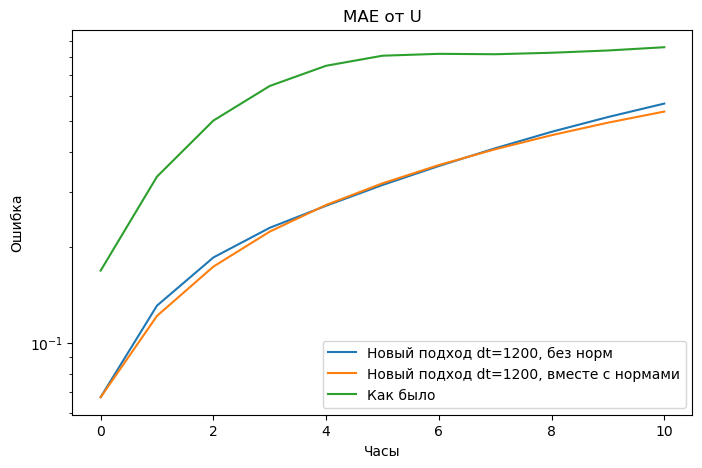

In [116]:
plt.figure(figsize=(8, 5))
plt.title("MАE от U")
plt.plot(u_mae_1200_bez, label='Новый подход dt=1200, без норм')
plt.plot(u_mae_1200, label='Новый подход dt=1200, вместе с нормами')
# plt.plot(u_mae_300_bez, label='dt=300, без норм')
plt.plot(u_mae_300, label='Как было')

# plt.plot(df_old_u_mae["u_mae_1200_bez"], label='v1 dt=1200, без норм')
# plt.plot(df_old_u_mae["u_mae_1200"], label='v1 dt=1200')
plt.yscale("log")
plt.xlabel("Часы")
plt.ylabel("Ошибка")
plt.legend()

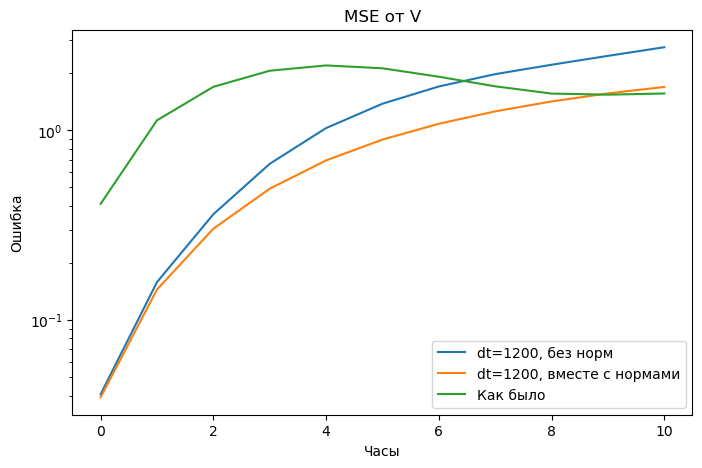

In [117]:
plt.figure(figsize=(8, 5))
plt.title("MSE от V")
plt.plot(v_mse_1200_bez, label='dt=1200, без норм')
plt.plot(v_mse_1200, label='dt=1200, вместе с нормами')
# plt.plot(v_mse_300_bez, label='dt=300, без норм')
plt.plot(v_mse_300, label='Как было')

# plt.plot(df_old_v_mse["v_mse_1200_bez"], label='v1 dt=1200, без норм')
# plt.plot(df_old_v_mse["v_mse_1200"], label='v1 dt=1200')
plt.yscale("log")
plt.xlabel("Часы")
plt.ylabel("Ошибка")
plt.legend()

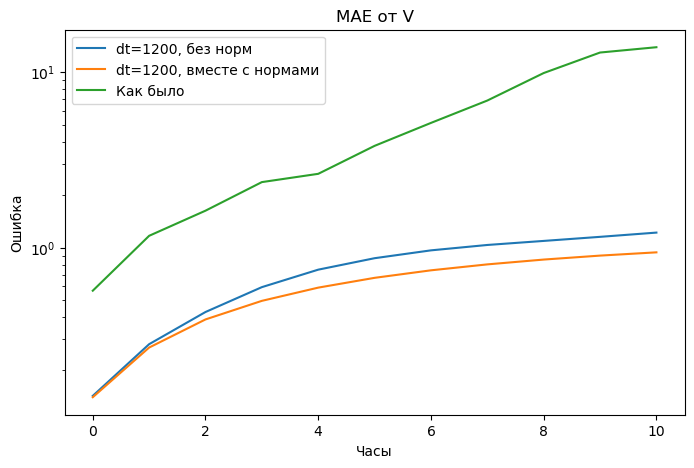

In [118]:
plt.figure(figsize=(8, 5))
plt.title("MАE от V")
plt.plot(v_mae_1200_bez, label='dt=1200, без норм')
plt.plot(v_mae_1200, label='dt=1200, вместе с нормами')
plt.plot(v_mae_300_bez, label='Как было')
# plt.plot(v_mae_300, label='dt=300, вместе с нормами')

# plt.plot(df_old_v_mae["v_mae_1200_bez"], label='v1 dt=1200, без норм')
# plt.plot(df_old_v_mae["v_mae_1200"], label='v1 dt=1200')
plt.yscale("log")
plt.xlabel("Часы")
plt.ylabel("Ошибка")
plt.legend()

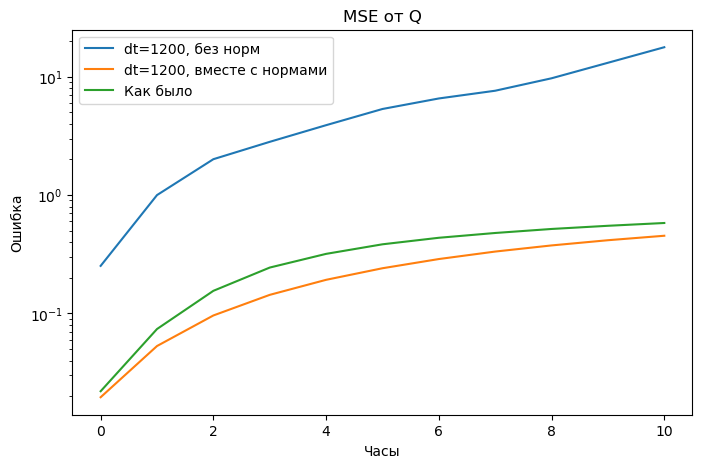

In [119]:
plt.figure(figsize=(8, 5))
plt.title("MSE от Q")
plt.plot(q_mse_1200_bez, label='dt=1200, без норм')
plt.plot(q_mse_1200, label='dt=1200, вместе с нормами')
# plt.plot(q_mse_300_bez, label='dt=300, без норм')
plt.plot(q_mse_300, label='Как было')

# plt.plot(df_old_q_mse["q_mse_1200_bez"], label='v1 dt=1200, без норм')
# plt.plot(df_old_q_mse["q_mse_1200"], label='v1 dt=1200')

plt.yscale("log")
plt.xlabel("Часы")
plt.ylabel("Ошибка")
plt.legend()

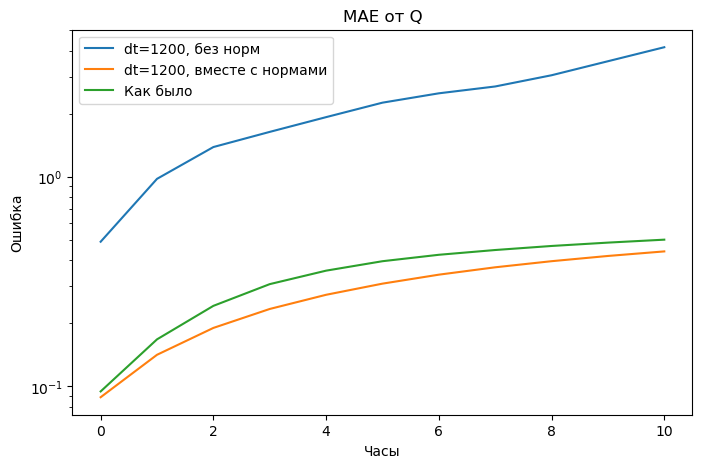

In [120]:
plt.figure(figsize=(8, 5))
plt.title("MАE от Q")
plt.plot(q_mae_1200_bez, label='dt=1200, без норм')
plt.plot(q_mae_1200, label='dt=1200, вместе с нормами')
# plt.plot(q_mae_300_bez, label='dt=300, без норм')
plt.plot(q_mae_300, label='Как было')
# plt.plot(df_old_q_mae["q_mae_1200_bez"], label='v1 dt=1200, без норм')
# plt.plot(df_old_q_mae["q_mae_1200"], label='v1 dt=1200')

plt.yscale("log")
plt.xlabel("Часы")
plt.ylabel("Ошибка")
plt.legend()

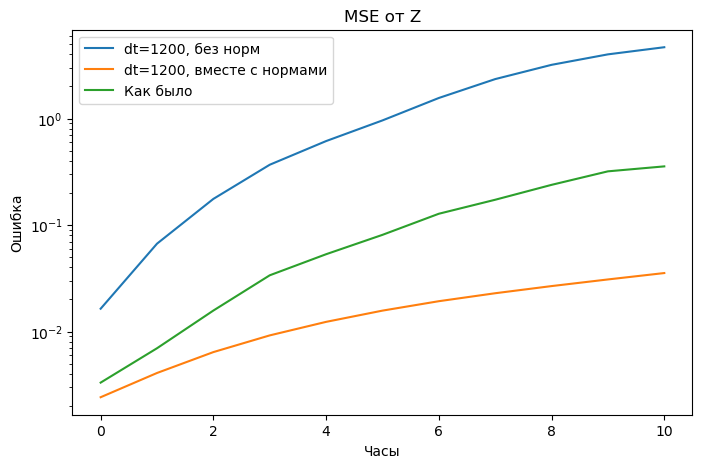

In [121]:
plt.figure(figsize=(8, 5))
plt.title("MSE от Z")
plt.plot(z_mse_1200_bez, label='dt=1200, без норм')
plt.plot(z_mse_1200, label='dt=1200, вместе с нормами')
# plt.plot(z_mse_300_bez, label='dt=300, без норм')
plt.plot(z_mse_300, label='Как было')

# plt.plot(df_old_z_mse["z_mse_1200_bez"], label='v1 dt=1200, без норм')
# plt.plot(df_old_z_mse["z_mse_1200"], label='v1 dt=1200')
plt.yscale("log")
plt.xlabel("Часы")
plt.ylabel("Ошибка")
plt.legend()

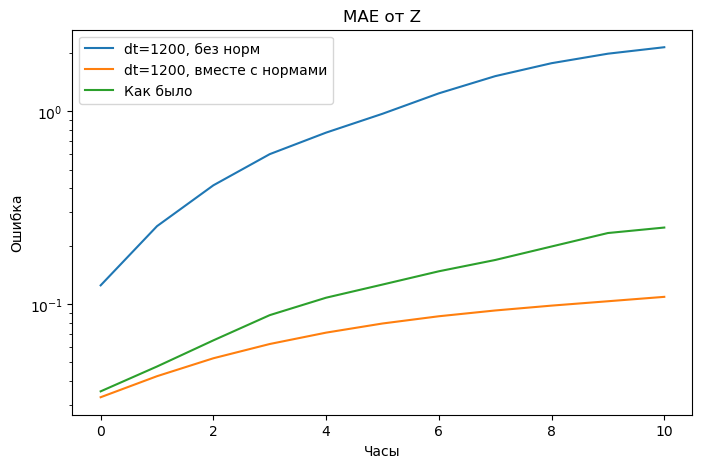

In [122]:
plt.figure(figsize=(8, 5))
plt.title("MАE от Z")
plt.plot(z_mae_1200_bez, label='dt=1200, без норм')
plt.plot(z_mae_1200, label='dt=1200, вместе с нормами')
# plt.plot(z_mae_300_bez, label='dt=300, без норм')
plt.plot(z_mae_300, label='Как было')

# plt.plot(df_old_z_mae["z_mae_1200_bez"], label='v1 dt=1200, без норм')
# plt.plot(df_old_z_mae["z_mae_1200"], label='v1 dt=1200')
plt.yscale("log")
plt.xlabel("Часы")
plt.ylabel("Ошибка")
plt.legend()

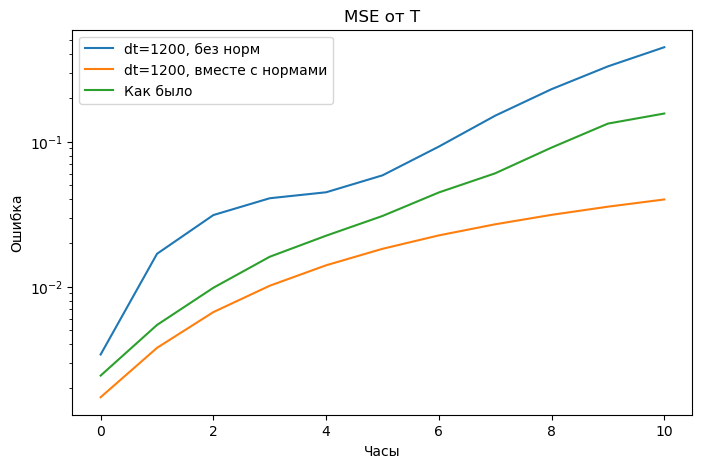

In [123]:
plt.figure(figsize=(8, 5))
plt.title("MSE от T")
plt.plot(t_mse_1200_bez, label='dt=1200, без норм')
plt.plot(t_mse_1200, label='dt=1200, вместе с нормами')
# plt.plot(t_mse_300_bez, label='dt=300, без норм')
plt.plot(t_mse_300, label='Как было')

# plt.plot(df_old_t_mse["t_mse_1200_bez"], label='v1 dt=1200, без норм')
# plt.plot(df_old_t_mse["t_mse_1200"], label='v1 dt=1200')
plt.yscale("log")
plt.xlabel("Часы")
plt.ylabel("Ошибка")
plt.legend()

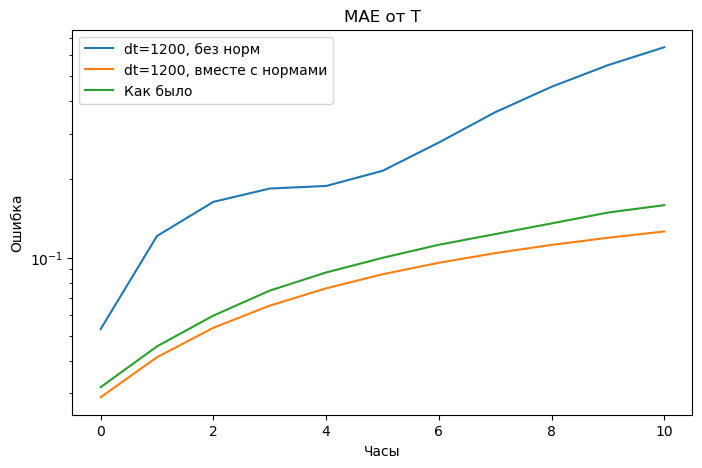

In [124]:
plt.figure(figsize=(8, 5))
plt.title("MАE от T")
plt.plot(t_mae_1200_bez, label='dt=1200, без норм')
plt.plot(t_mae_1200, label='dt=1200, вместе с нормами')
# plt.plot(t_mae_300_bez, label='dt=300, без норм')
plt.plot(t_mae_300, label='Как было')

# plt.plot(df_old_t_mae["t_mae_1200_bez"], label='v1 dt=1200, без норм')
# plt.plot(df_old_t_mae["t_mae_1200"], label='v1 dt=1200')
plt.yscale("log")
plt.xlabel("Часы")
plt.ylabel("Ошибка")
plt.legend()

In [24]:
# Create lists to store losses for each index
indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  # 13 indices
u_mse_by_index_1200_bez = {idx: [] for idx in indices}
u_mae_by_index_1200_bez = {idx: [] for idx in indices}
v_mse_by_index_1200_bez = {idx: [] for idx in indices}
v_mae_by_index_1200_bez = {idx: [] for idx in indices}

kernel = PDE_kernel(block_dt=1200)
x_0 = x_train[:, 0, 4:]
x_0 = x_to_zquvtw(x_0)

for i in range(11):
    x_1 = x_train[:, i+1, 4:]
    x_1 = x_to_zquvtw(x_1)
    
    # Apply kernel 3 times
    for j in range(3):
        x_0 = kernel(x_0)
    
    # Unpack vectors
    z_0, t_0, q_0, u_0, v_0 = x_0.chunk(5, dim=1)
    z_1, t_1, q_1, u_1, v_1 = x_1.chunk(5, dim=1)
    
    # Calculate losses for each of the 13 indices
    for idx in indices:
        if idx < u_0.shape[1]:  # Check if index is within bounds
            u_mse_by_index_1200_bez[idx].append(mse_loss(u_0[:, idx], u_1[:, idx]).item())
            u_mae_by_index_1200_bez[idx].append(mae_loss(u_0[:, idx], u_1[:, idx]).item())
            v_mse_by_index_1200_bez[idx].append(mse_loss(v_0[:, idx], v_1[:, idx]).item())
            v_mae_by_index_1200_bez[idx].append(mae_loss(v_0[:, idx], v_1[:, idx]).item())

# # If you need the original variables maintained for backward compatibility
# u_mse_0_1200_bez = u_mse_by_index[0]
# u_mae_0_1200_bez = u_mae_by_index[0]
# u_mse_1_1200_bez = u_mse_by_index[1] if 1 in indices else []
# u_mae_1_1200_bez = u_mae_by_index[1] if 1 in indices else []

# # Print some sample results
# print(f"MSE for index 0: {u_mse_by_index[0]}")
# print(f"MAE for index 0: {u_mae_by_index[0]}")
# print(f"MSE for index 5: {u_mse_by_index[5]}")
# print(f"MAE for index 5: {u_mae_by_index[5]}")

In [25]:
# Create lists to store losses for each index
indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  # 13 indices
u_mse_by_index_1200 = {idx: [] for idx in indices}
u_mae_by_index_1200 = {idx: [] for idx in indices}
v_mse_by_index_1200 = {idx: [] for idx in indices}
v_mae_by_index_1200 = {idx: [] for idx in indices}

kernel = PDE_kernel(block_dt=1200, norm=True)
x_0 = x_train[:, 0, 4:]
x_0 = x_to_zquvtw(x_0)

for i in range(11):
    x_1 = x_train[:, i+1, 4:]
    x_1 = x_to_zquvtw(x_1)
    
    # Apply kernel 3 times
    for j in range(3):
        x_0 = kernel(x_0)
    
    # Unpack vectors
    z_0, t_0, q_0, u_0, v_0 = x_0.chunk(5, dim=1)
    z_1, t_1, q_1, u_1, v_1 = x_1.chunk(5, dim=1)
    
    # Calculate losses for each of the 13 indices
    for idx in indices:
        if idx < u_0.shape[1]:  # Check if index is within bounds
            u_mse_by_index_1200[idx].append(mse_loss(u_0[:, idx], u_1[:, idx]).item())
            u_mae_by_index_1200[idx].append(mae_loss(u_0[:, idx], u_1[:, idx]).item())
            v_mse_by_index_1200[idx].append(mse_loss(v_0[:, idx], v_1[:, idx]).item())
            v_mae_by_index_1200[idx].append(mae_loss(v_0[:, idx], v_1[:, idx]).item())

In [27]:
# Create lists to store losses for each index
indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  # 13 indices
u_mse_by_index_300 = {idx: [] for idx in indices}
u_mae_by_index_300 = {idx: [] for idx in indices}
v_mse_by_index_300 = {idx: [] for idx in indices}
v_mae_by_index_300 = {idx: [] for idx in indices}

kernel = PDE_kernel(block_dt=300, norm=True)
x_0 = x_train[:, 0, 4:]
x_0 = x_to_zquvtw(x_0)

for i in range(11):
    x_1 = x_train[:, i+1, 4:]
    x_1 = x_to_zquvtw(x_1)
    
    # Apply kernel 3 times
    for j in range(12):
        x_0 = kernel(x_0)
    
    # Unpack vectors
    z_0, t_0, q_0, u_0, v_0 = x_0.chunk(5, dim=1)
    z_1, t_1, q_1, u_1, v_1 = x_1.chunk(5, dim=1)
    
    # Calculate losses for each of the 13 indices
    for idx in indices:
        if idx < u_0.shape[1]:  # Check if index is within bounds
            u_mse_by_index_300[idx].append(mse_loss(u_0[:, idx], u_1[:, idx]).item())
            u_mae_by_index_300[idx].append(mae_loss(u_0[:, idx], u_1[:, idx]).item())
            v_mse_by_index_300[idx].append(mse_loss(v_0[:, idx], v_1[:, idx]).item())
            v_mae_by_index_300[idx].append(mae_loss(v_0[:, idx], v_1[:, idx]).item())

RuntimeError: The expanded size of the tensor (64) must match the existing size (32) at non-singleton dimension 2.  Target sizes: [100, 13, 64, 1].  Tensor sizes: [1, 1, 32, 1]

In [ ]:
# Create lists to store losses for each index
indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  # 13 indices
u_mse_by_index_300_bez = {idx: [] for idx in indices}
u_mae_by_index_300_bez = {idx: [] for idx in indices}
v_mse_by_index_300_bez = {idx: [] for idx in indices}
v_mae_by_index_300_bez = {idx: [] for idx in indices}

kernel = PDE_kernel(block_dt=300)
x_0 = x_train[:, 0, 4:]
x_0 = x_to_zquvtw(x_0)

for i in range(11):
    x_1 = x_train[:, i+1, 4:]
    x_1 = x_to_zquvtw(x_1)
    
    # Apply kernel 3 times
    for j in range(12):
        x_0 = kernel(x_0)
    
    # Unpack vectors
    z_0, t_0, q_0, u_0, v_0 = x_0.chunk(5, dim=1)
    z_1, t_1, q_1, u_1, v_1 = x_1.chunk(5, dim=1)
    
    # Calculate losses for each of the 13 indices
    for idx in indices:
        if idx < u_0.shape[1]:  # Check if index is within bounds
            u_mse_by_index_300_bez[idx].append(mse_loss(u_0[:, idx], u_1[:, idx]).item())
            u_mae_by_index_300_bez[idx].append(mae_loss(u_0[:, idx], u_1[:, idx]).item())
            v_mse_by_index_300_bez[idx].append(mse_loss(v_0[:, idx], v_1[:, idx]).item())
            v_mae_by_index_300_bez[idx].append(mae_loss(v_0[:, idx], v_1[:, idx]).item())

In [28]:
levels_list = [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000]
levels = {idx: levels_list[idx] for idx in range(len(levels_list))}

In [33]:
u_mse_by_index_1200_bez[12]

[0.010346650145947933,
 0.034650322049856186,
 0.07036330550909042,
 0.1244909018278122,
 0.2026117444038391,
 0.3027515709400177,
 0.42924535274505615,
 0.578792154788971,
 0.7557841539382935,
 0.9527831077575684,
 1.1439054012298584]

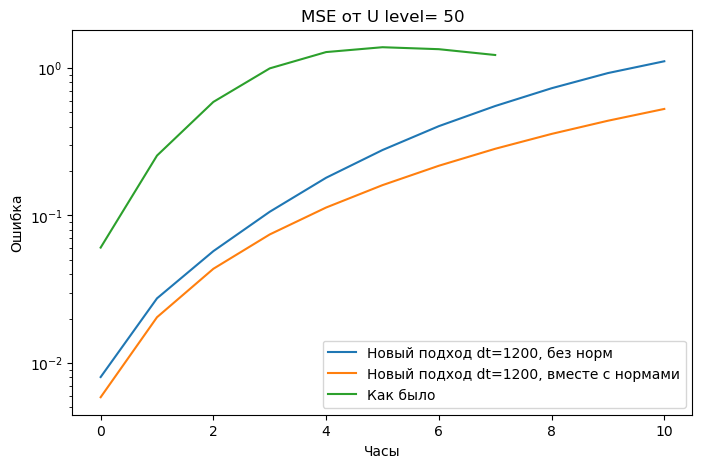

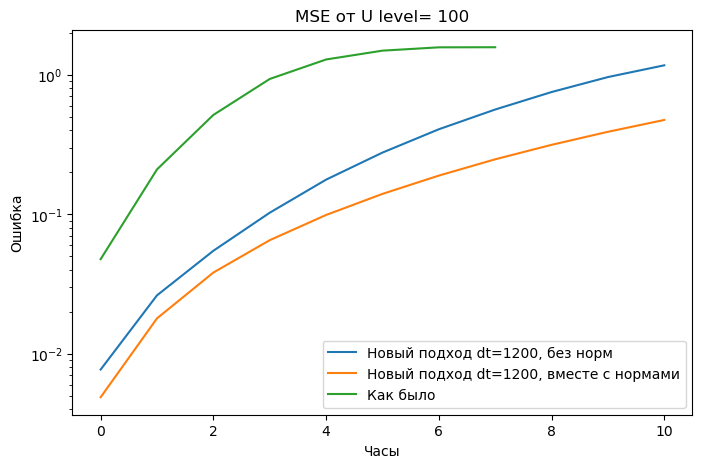

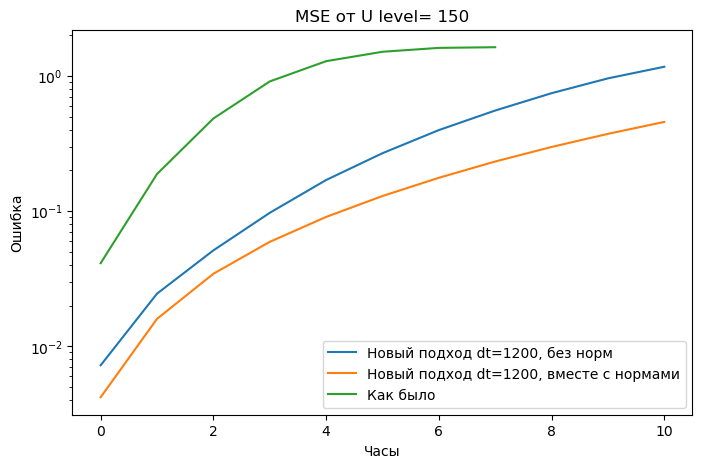

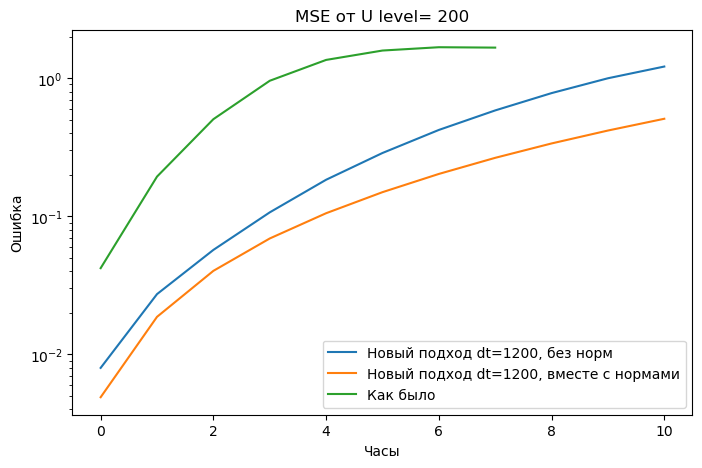

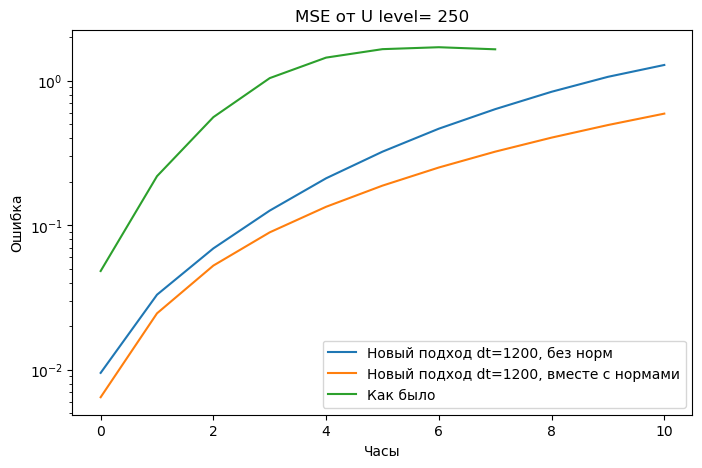

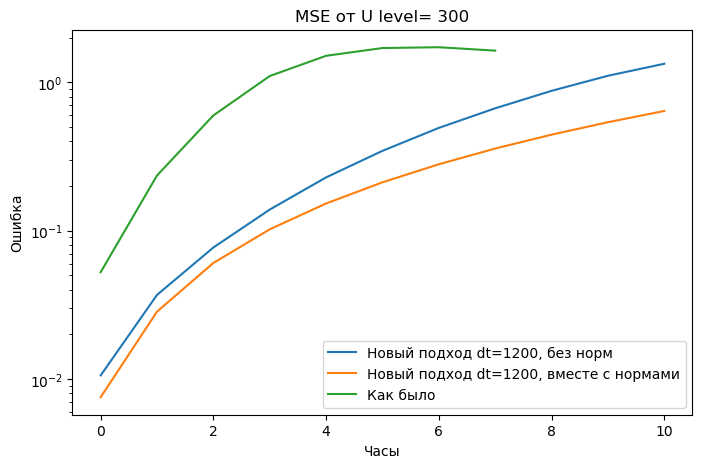

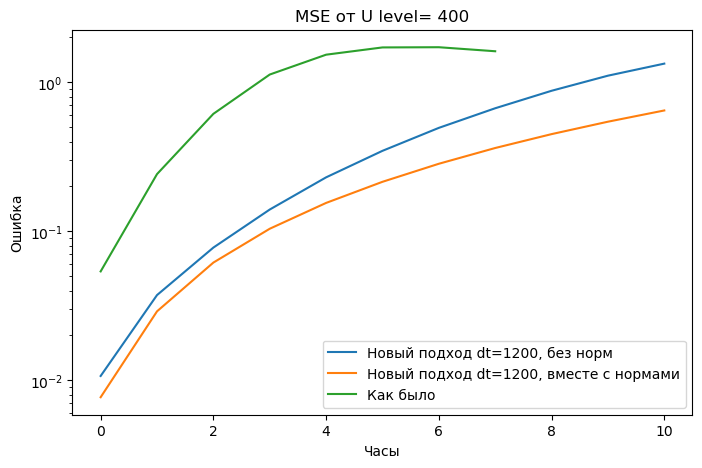

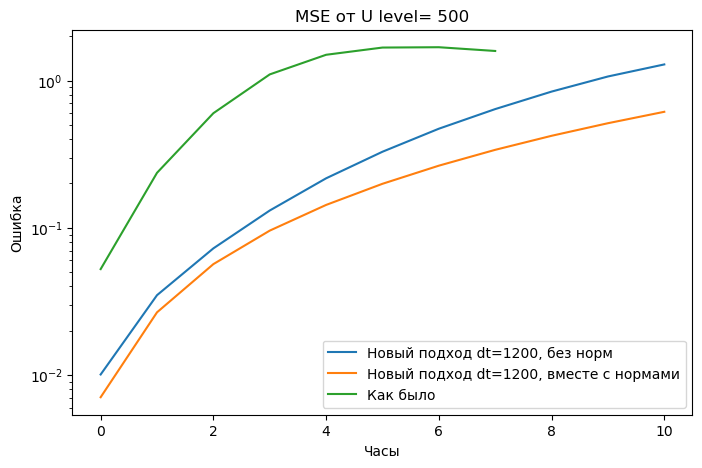

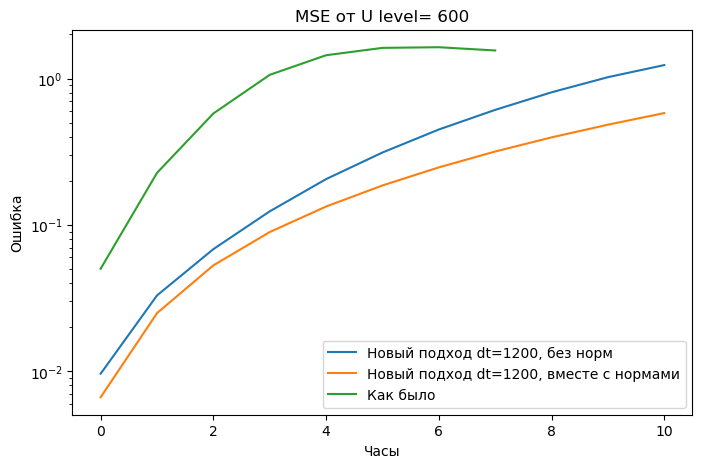

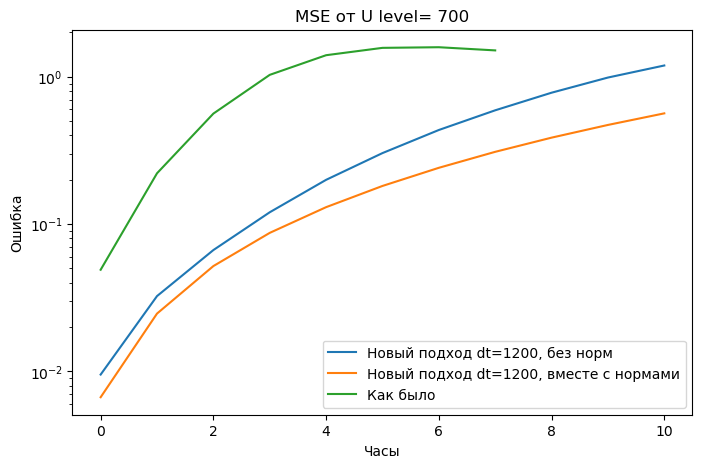

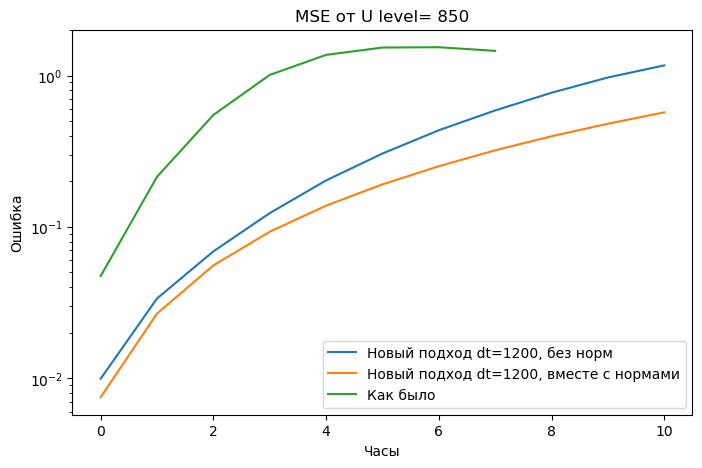

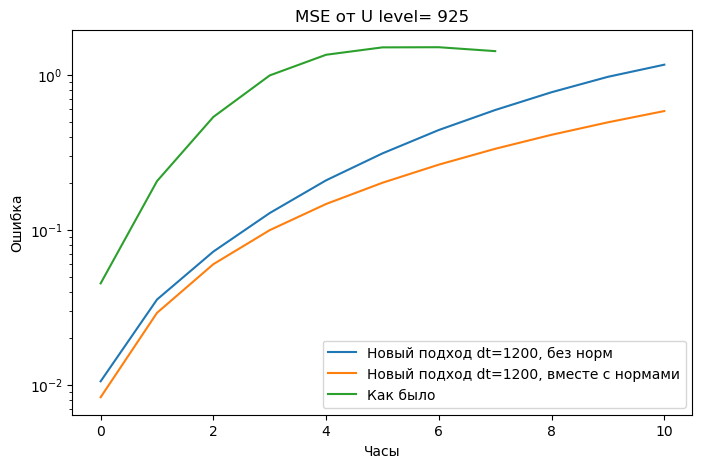

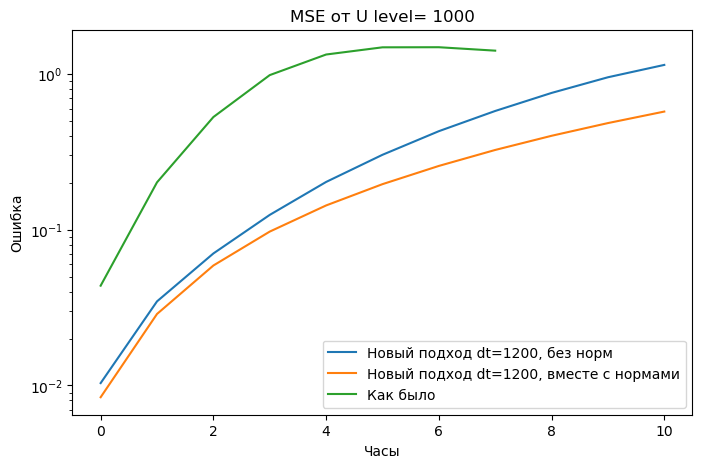

In [29]:
for idx in levels.keys():
    plt.figure(figsize=(8, 5))
    plt.title(f"MSE от U level= {levels[idx]}")
    plt.plot(u_mse_by_index_1200_bez[idx], label='Новый подход dt=1200, без норм')
    plt.plot(u_mse_by_index_1200[idx], label='Новый подход dt=1200, вместе с нормами')
    # plt.plot(u_mae_300_bez, label='dt=300, без норм')
    plt.plot(u_mse_by_index_300[idx], label='Как было')

    # plt.plot(df_old_u_mae["u_mae_1200_bez"], label='v1 dt=1200, без норм')
    # plt.plot(df_old_u_mae["u_mae_1200"], label='v1 dt=1200')
    plt.yscale("log")
    plt.xlabel("Часы")
    plt.ylabel("Ошибка")
    plt.legend()

In [ ]:
for idx in levels.keys():
    plt.figure(figsize=(8, 5))
    plt.title(f"MAE от U level= {levels[idx]}")
    plt.plot(u_mae_by_index_1200_bez[idx], label='Новый подход dt=1200, без норм')
    plt.plot(u_mae_by_index_1200[idx], label='Новый подход dt=1200, вместе с нормами')
    # plt.plot(u_mae_300_bez, label='dt=300, без норм')
    plt.plot(u_mae_by_index_300[idx], label='Как было')

    # plt.plot(df_old_u_mae["u_mae_1200_bez"], label='v1 dt=1200, без норм')
    # plt.plot(df_old_u_mae["u_mae_1200"], label='v1 dt=1200')
    plt.yscale("log")
    plt.xlabel("Часы")
    plt.ylabel("Ошибка")
    plt.legend()